In [1]:
#for using BERT, DistilBERT, GPT , etc. and datasets
!pip install transformers datasets -q

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from datasets import load_dataset
from transformers import DistilBertTokenizerFast
import pandas as pd
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split

In [4]:
#download IMDb dataset from Hugging Face
url = "https://huggingface.co/datasets/scikit-learn/imdb/resolve/main/IMDB%20Dataset.csv"
df = pd.read_csv(url)
print(df.columns)
print(df.shape)
df.head()

Index(['review', 'sentiment'], dtype='object')
(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

In [6]:
df['sentiment'].isna().sum()

np.int64(0)

In [7]:
df_small = df.sample(n=2000, random_state=42).reset_index(drop=True)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_small['review'],
    df_small['sentiment'],
    test_size=0.2,
    stratify=df_small['sentiment'],
    random_state=42
)

In [8]:
#load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [9]:
#Tokenize datasets
train_encodings = tokenizer(
    list(train_texts),
    truncation=True,
    padding=True,
    max_length=128
)

test_encodings = tokenizer(
    list(test_texts),
    truncation=True,
    padding=True,
    max_length=128
)

In [10]:
#to tf.data.Dataset fir using tensorflow
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    list(train_labels)
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    list(test_labels)
)).batch(32)

In [11]:
model = TFDistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were n

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [13]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=3
)

Epoch 1/3
50/50 [==============================] - 1277s 25s/step - loss: 0.5683 - accuracy: 0.6794 - val_loss: 0.4102 - val_accuracy: 0.8150
Epoch 2/3
50/50 [==============================] - 1232s 25s/step - loss: 0.3112 - accuracy: 0.8644 - val_loss: 0.5397 - val_accuracy: 0.7875
Epoch 3/3
50/50 [==============================] - 1153s 23s/step - loss: 0.1840 - accuracy: 0.9306 - val_loss: 0.4927 - val_accuracy: 0.8125


In [14]:
model.save_pretrained("/content/drive/MyDrive/sentiment-analysis-bert/model")
tokenizer.save_pretrained("/content/drive/MyDrive/sentiment-analysis-bert/model")

('/content/drive/MyDrive/sentiment-analysis-bert/model/tokenizer_config.json',
 '/content/drive/MyDrive/sentiment-analysis-bert/model/special_tokens_map.json',
 '/content/drive/MyDrive/sentiment-analysis-bert/model/vocab.txt',
 '/content/drive/MyDrive/sentiment-analysis-bert/model/added_tokens.json',
 '/content/drive/MyDrive/sentiment-analysis-bert/model/tokenizer.json')

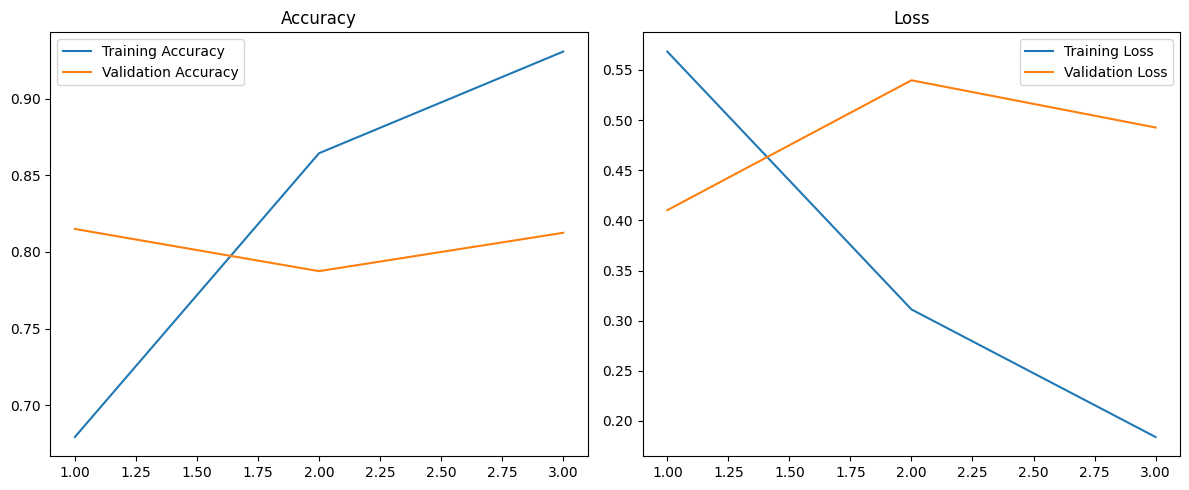

In [15]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

In [22]:
y_true = []
y_pred = []

In [24]:
for batch in test_dataset:
    inputs, labels = batch
    logits = model(inputs, training=False).logits
    predictions = tf.argmax(logits, axis=1).numpy()

    y_pred.extend(predictions)
    y_true.extend(labels.numpy())

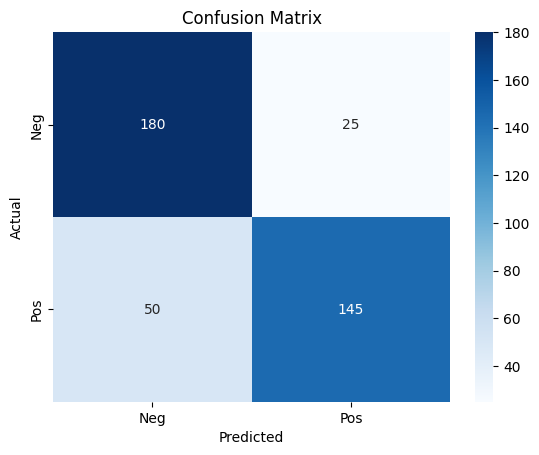

In [25]:
#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Neg", "Pos"], yticklabels=["Neg", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [26]:
#Classification Report
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.78      0.88      0.83       205
    Positive       0.85      0.74      0.79       195

    accuracy                           0.81       400
   macro avg       0.82      0.81      0.81       400
weighted avg       0.82      0.81      0.81       400

